The Goal of this analysis will be to see what predict the Monthly rainfall in 2023 based on all previous weather information. 

### Load in the Relevant Libraries 

In [95]:
import pandas as pd
import numpy as np 
import statistics as st
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

### Load in the data

In [21]:
rainfall = pd.read_csv("Gingin_Rainfall_data.csv")

Now that we have loaded the rainfall data, let's explore the data. The first two things that we will be looking for is trend and seasonal variation. To observe this, let's start with a basic time plot. 

<Axes: xlabel='time', ylabel='Monthly Precipitation Total (millimetres)'>

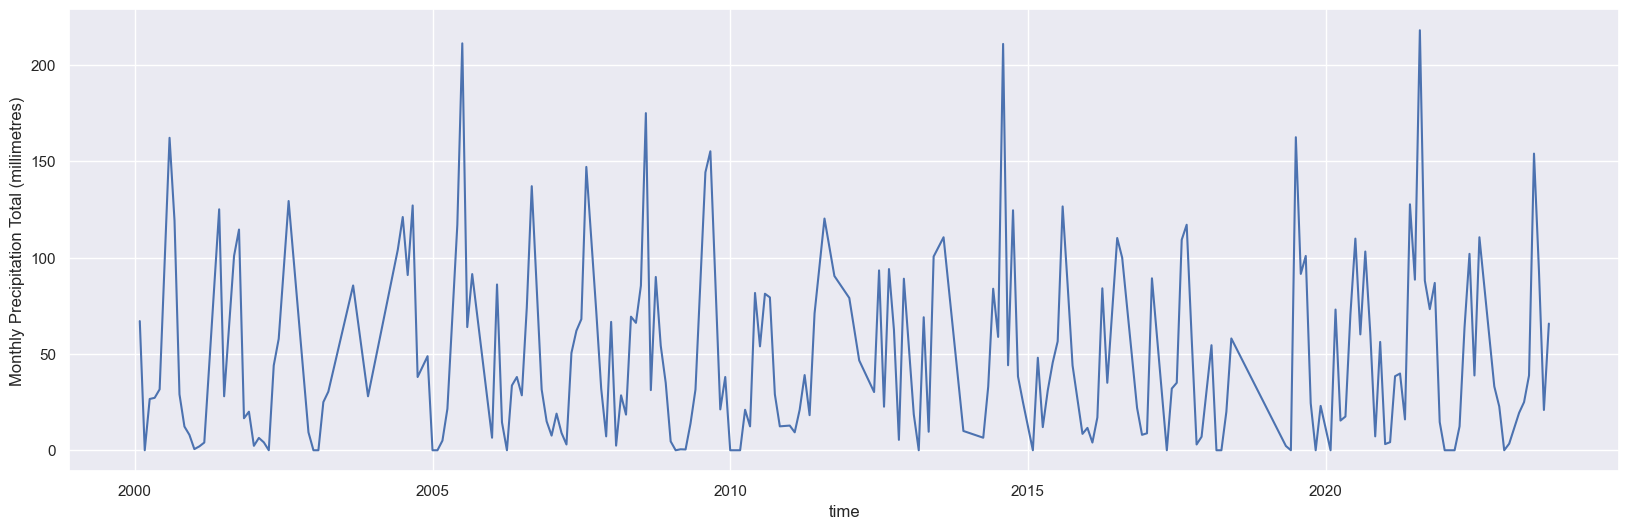

In [36]:
rainfall = rainfall.assign(time = rainfall["Year"] + rainfall["Month"]/12)
rainfall_21st_century = rainfall[rainfall["Year"] >= 2000]


sns.set(rc={'figure.figsize':(20,6)})
# sns.lineplot(data=rainfall, x="time", y = "Monthly Precipitation Total (millimetres)")
sns.lineplot(data=rainfall_21st_century, x = "time", y = "Monthly Precipitation Total (millimetres)")

We can see from this that there appears to be some seasonal variation (dips in summer and peaks during winter). Let's now investigate if there is a trend by looking at the total recorded rainfall each year.   

<Axes: xlabel='Year', ylabel='total'>

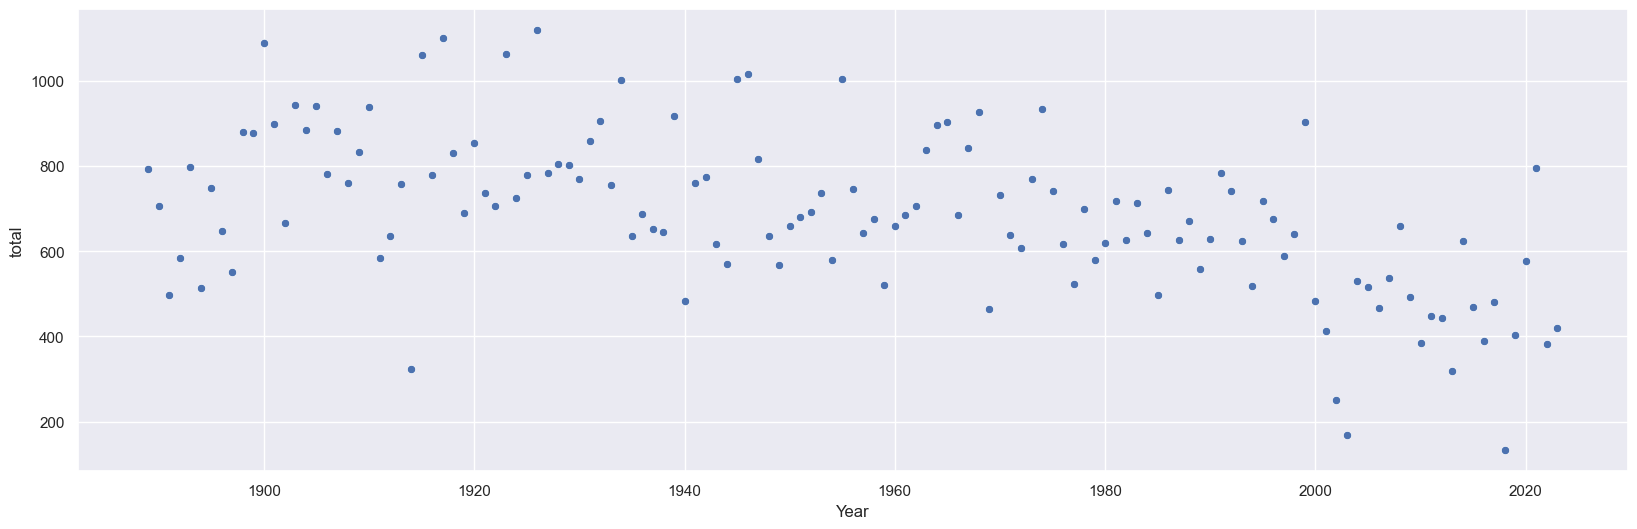

In [44]:
rainfall_yearly_precip = rainfall.groupby(["Year"]).agg(
    total=pd.NamedAgg(column="Monthly Precipitation Total (millimetres)", aggfunc="sum"))

sns.scatterplot(data=rainfall_yearly_precip, x = "Year", y= "total")

# sns.regplot(data = rainfall_yearly_precip, x= "Year", y= "mean")

There appears to be a downwards trend in the total rainfall. Now let's observe the level of autocorrelation in the data now. Test.

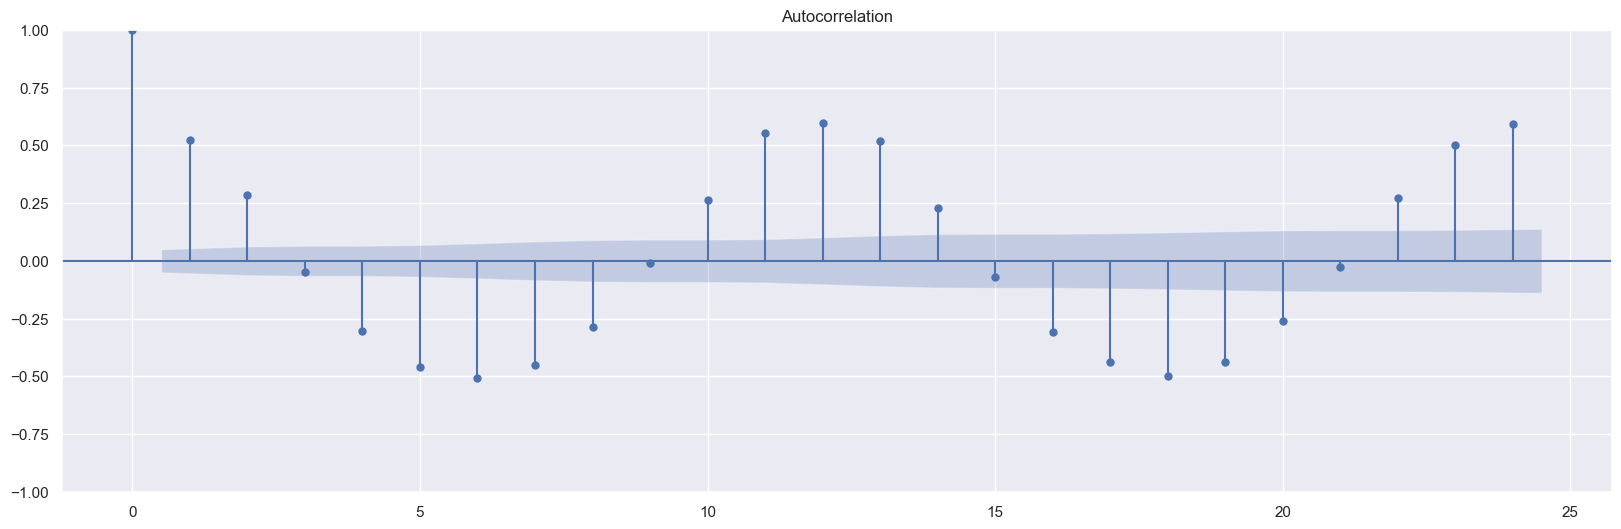

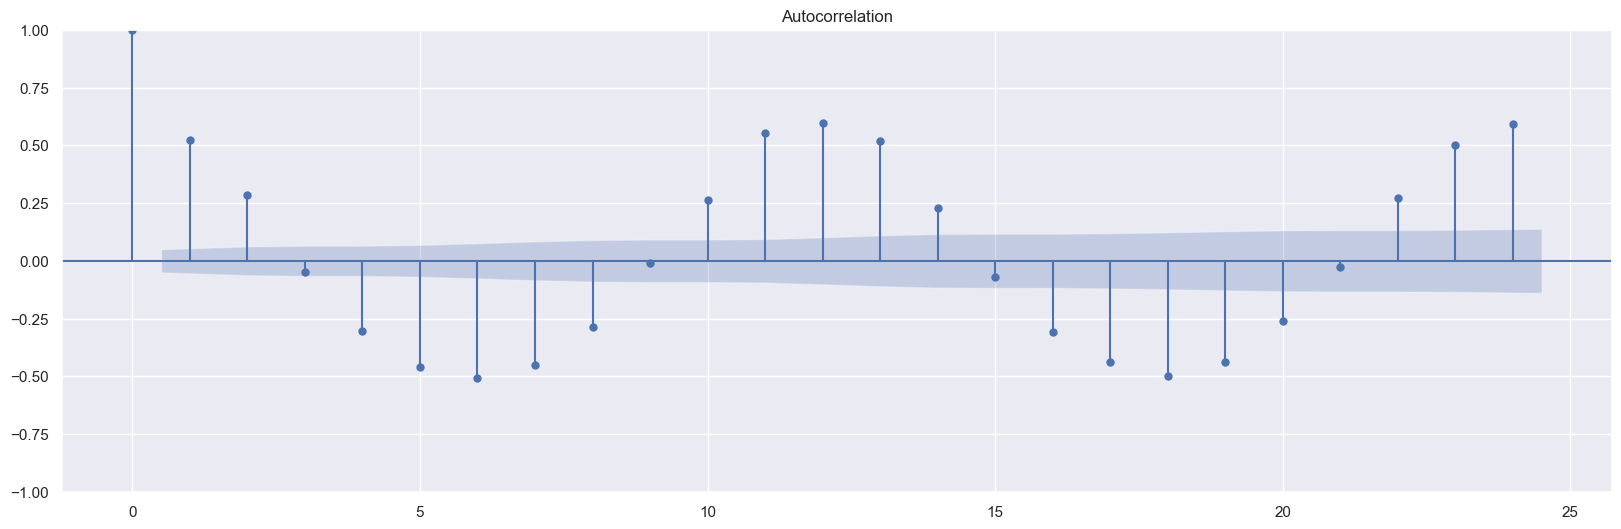

In [38]:
plot_acf(rainfall["Monthly Precipitation Total (millimetres)"], lags=24)

We can see here that the autocorrelation appears to show period of around 12 (also as expected). Let's now try to model this as a SARIMA model. 

In [99]:
rainfall_train = rainfall[(rainfall["Year"] < 2023) & (rainfall["Year"] > 2001)]

sarima_model = sm.tsa.SARIMAX(rainfall_train["Monthly Precipitation Total (millimetres)"], order= (2,0,0), seasonal_order= (1,0,1,12)).fit()

c:\Users\283146E\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\283146E\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [100]:
print(sarima_model.summary())

prediction = sarima_model.get_forecast(steps = 9)

                                           SARIMAX Results                                           
Dep. Variable:     Monthly Precipitation Total (millimetres)   No. Observations:                  193
Model:                      SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1015.855
Date:                                       Wed, 11 Oct 2023   AIC                           2041.711
Time:                                               13:05:33   BIC                           2058.024
Sample:                                                    0   HQIC                          2048.317
                                                       - 193                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3465     

c:\Users\283146E\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\283146E\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Plot of the Prediction vs actual values

<Axes: xlabel='Month', ylabel='Monthly Precipitation (mm)'>

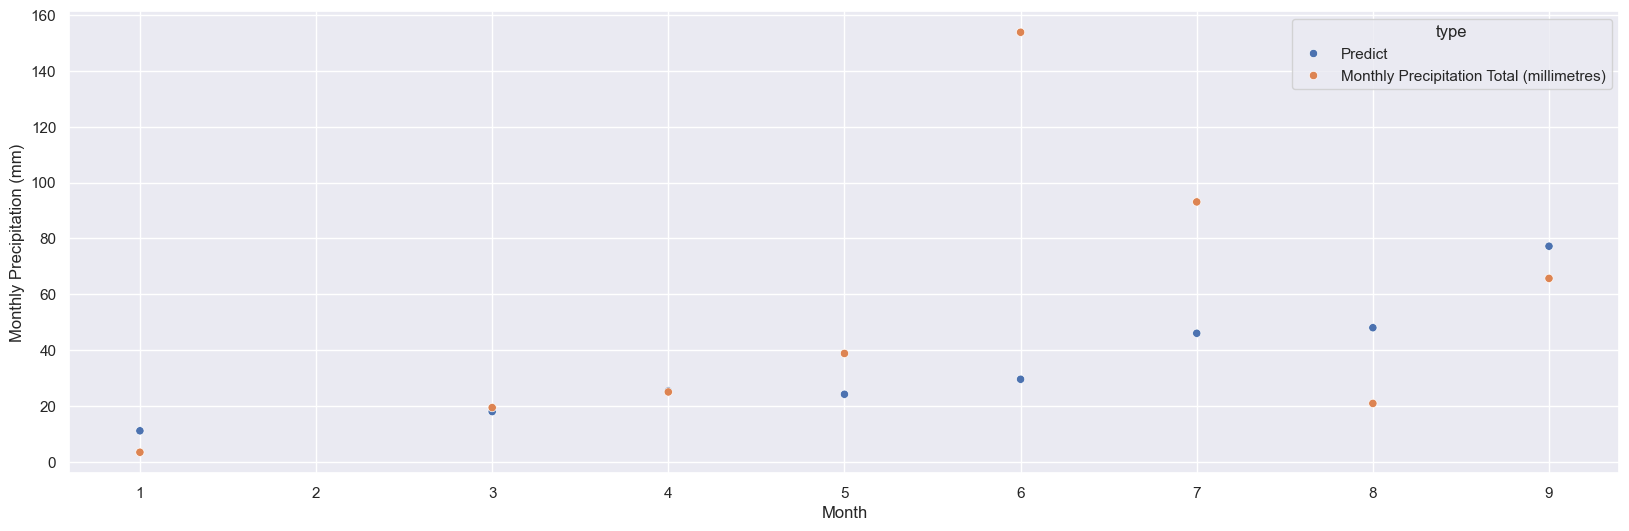

In [101]:
predict = prediction.predicted_mean

dictionary_of_lists = {
    'Predict': predict.to_list(), 
    'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
# Create the DataFrame
df1 = pd.DataFrame(dictionary_of_lists)

actual = rainfall[rainfall["Year"] == 2023]

final_df = pd.merge(actual, df1, left_on='Month', right_on='Month', how='left')

# Wide to long format
final_df_long = final_df.melt(id_vars= "Month", var_name='type', value_vars=['Predict', 'Monthly Precipitation Total (millimetres)'], value_name="Monthly Precipitation (mm)")

sns.scatterplot(final_df_long, x = "Month", y = "Monthly Precipitation (mm)", hue = "type")

In [102]:
Model_performance_rmse =  st.mean((final_df["Monthly Precipitation Total (millimetres)"] - final_df["Predict"])**2)**0.5

Model_performance_rmse

48.50423595507155

The model performed quite well in prediction (RMSE 48.5), except for the month of June where it was quite off. Maybe this value is an outlier in terms of june rainfall? Let's observe the june rainfall trends.

In [ ]:
rainfall_june = rainfall[rainfall["Month"] == 6]

sns.scatterplot(data=rainfall_june, x = "Year", y = "Monthly Precipitation Total (millimetres)")

Let's zoom into the past 20 years, where this does appear to be an outlier. 

<Axes: xlabel='Year', ylabel='Monthly Precipitation Total (millimetres)'>

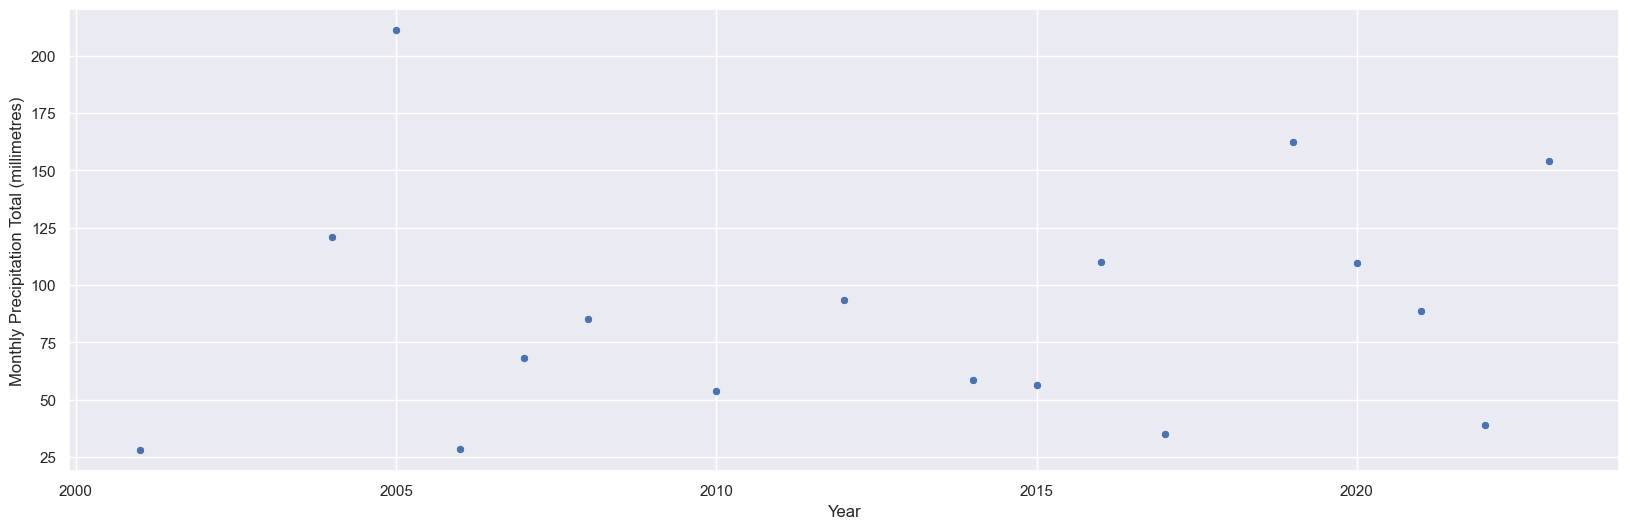

In [92]:
rainfall_june = rainfall[(rainfall["Month"] == 6) & (rainfall["Year"] >= 2000)]

sns.scatterplot(data=rainfall_june, x = "Year", y = "Monthly Precipitation Total (millimetres)")